[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/usnistgov/AFL-agent/blob/main/docs/source/tutorials/autosas_tutorial.ipynb)

# Basic Fitting with AutoSAS

This tutorial demonstrates how to use AutoSAS to fit small-angle scattering (SAS) data with different models. We'll explore how to:
- Load and prepare SAS data
- Set up an AutoSAS fit for a single model
- Compare and evaluate the fits

## Google Colab Setup

Only uncomment and run the next cell if you are running this notebook in Google Colab or if don't already have the AFL-agent package installed.

In [ ]:
# !pip install git+https://github.com/usnistgov/AFL-agent.git

## Getting Started

First, let's import the necessary packages and load our example dataset:

In [5]:
import matplotlib.pyplot as plt

from AFL.double_agent import *
from AFL.double_agent.AutoSAS import AutoSAS


Next, let's load the example dataset. We'll subselect only part of the dataset to work with

In [6]:
from AFL.double_agent.data import example_dataset2

# Load example dataset and select the mass_fractal model
ds = example_dataset2()
ds = ds.where(ds.model == 'surface_fractal',drop=True)
ds

<xarray.Dataset> Size: 17kB
Dimensions:  (sample: 10, q: 100)
Coordinates:
  * q        (q) float64 800B 0.001 0.001072 0.00115 ... 0.8697 0.9326 1.0
Dimensions without coordinates: sample
Data variables:
    I        (sample, q) float64 8kB 5.465e+03 4.598e+03 3.859e+03 ... 1.08 1.03
    dI       (sample, q) float64 8kB 545.9 429.3 342.6 ... 0.1025 0.1025 0.1025
    model    (sample) object 80B 'surface_fractal' ... 'surface_fractal'

Let's plot the data so we can see what we're trying to fit.

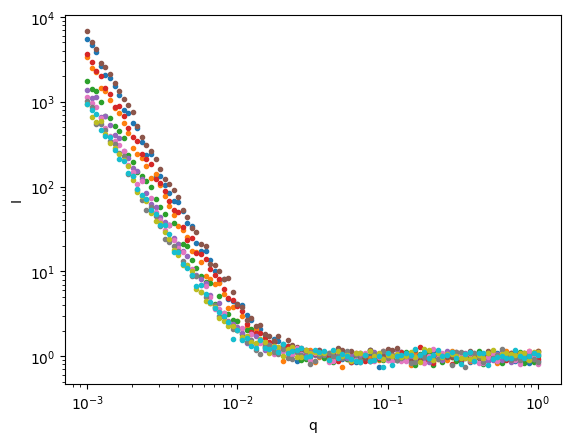

In [7]:
ds.I.plot.line(x='q',xscale='log',yscale='log',marker='.',ls='None',add_legend=False);

## Defining the Fit
The first step to AutoSAS is to define which models we'd like to fit. Let's start with a single model

The model inputs are defined as a list of dictionaries, where each dictionary specifies:
- `name`: A user-defined name for the model
- `sasmodel`: The name of the model in the sasmodels library to use
- `q_min`: the minimum q_value to consider in the fit
- `q_max`: the maximum q_value to consider in the fit
- `fit_params`: A dictionary of parameters for the model, where:
  - the `value` field determines the initial starting value for the parameter optimization
  - the `bounds` field determines the range that the optimizer can use to fit the data. Restricting this range is very important to achieving a proper fit
    - Parameters with "bounds" will be fit within those bounds
    - Parameters without bounds will be held constant at the specified value

In the example below, "power" and "scale" will be fit since they have bounds,
while "background" will be held constant at 1.0


In [8]:
model_inputs = [
    {
        "name": "surface_fractal", # your name for the model, can be anything
        "sasmodel": "power_law", # the name of the sasmodel in the sasmodels library
        'q_min':0.001,
        'q_max':1.0,
        "fit_params": {
            "power": {"value": 4, "bounds": (3, 4)},
            "scale": {"value": 1.0, "bounds": (1e-6,1e-3)},
            "background": {"value": 1.0,},
        },
    },
]

Now we'll create a `Pipeline` with a single `AutoSAS` pipeline operation.

The AutoSAS pipeline operation takes several key arguments:

- `sas_variable`: The name of the variable containing the SAS intensity data
- `sas_err_variable`: The name of the variable containing the uncertainty in the intensity data
- `q_dim`: The name of the dimension containing the q values
- `output_prefix`: A prefix to add to all output variables from the fit
- `model_inputs`: A list of dictionaries defining the models to fit, as described above

Additional optional arguments include:
- `sample_dim`: The name of the sample dimension (default: 'sample')
- `fit_range`: A tuple of (qmin, qmax) to restrict the q range used for fitting
- `max_evals`: Maximum number of function evaluations for the fit (default: 1000)
- `method`: The optimization method to use (default: 'leastsq')


## Building and Executing the Pipeline

In [14]:
with Pipeline() as p:
    AutoSAS(
        sas_variable='I',
        sas_err_variable='dI',
        q_variable = 'q',
        output_prefix='fit',
        model_inputs=model_inputs,
    )
p.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <AutoSAS>                           ['q', 'I', 'dI'] ---> ['fit_all_chisq']

Input Variables
---------------
0) q
1) I
2) dI

Output Variables
----------------
0) fit_all_chisq


Now we're ready to fit! 

In [15]:
ds_result = p.calculate(ds)
ds_result

  0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 35kB
Dimensions:                    (sample: 10, q: 100, models: 1,
                                surface_fractal_params: 3,
                                fit_q_surface_fractal: 100)
Coordinates:
  * q                          (q) float64 800B 0.001 0.001072 ... 0.9326 1.0
  * models                     (models) <U15 60B 'surface_fractal'
  * surface_fractal_params     (surface_fractal_params) <U26 312B 'surface_fr...
  * fit_q_surface_fractal      (fit_q_surface_fractal) float64 800B 0.001 ......
Dimensions without coordinates: sample
Data variables:
    I                          (sample, q) float64 8kB 5.465e+03 ... 1.03
    dI                         (sample, q) float64 8kB 545.9 429.3 ... 0.1025
    model                      (sample) object 80B 'surface_fractal' ... 'sur...
    sas_fit_sample             (sample) int64 80B 0 1 2 3 4 5 6 7 8 9
    fit_all_chisq              (sample, models) float64 80B 1.023 ... 1.083
    probabilities              (sample, models) float64 80B 1.0 1.0 ... 1.0 1.0
    surface_fractal_fit_val    (surface_fractal_params, sample) float64 240B ...
    surface_fractal_fit_err    (surface_fractal_params, sample) float64 240B ...
    fit_I_surface_fractal      (sample, fit_q_surface_fractal) float64 8kB 5....
    residuals_surface_fractal  (sample, fit_q_surface_fractal) float64 8kB -0...

This is a large and complicated dataset, but it contains all of the information from the fit, including:

- The fitted parameter values for each model (e.g. `surface_fractal_fit_val`) 
- The uncertainties in the fitted parameters (e.g. `surface_fractal_fit_err`)
- The model intensities at each q value (e.g. `fit_I_surface_fractal`)
- The residuals between the model and data (e.g. `residuals_surface_fractal`) 
- The chi-squared values for each fit (`fit_all_chisq`)
- The q values used for the fit (e.g. `fit_q_surface_fractal`)

We can use this information to evaluate the quality of the fits and compare different models. Let's plot some of the fits:

## Evaluating the Fit Results

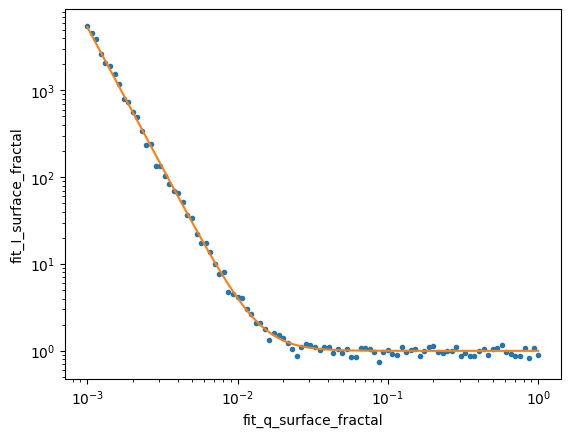

In [16]:
data_index = 0
ds_result.isel(sample=data_index).I.plot.line(x='q',xscale='log',yscale='log',marker='.',ls='None',add_legend=False);
ds_result.isel(sample=data_index).fit_I_surface_fractal.plot.line(x='fit_q_surface_fractal',xscale='log',yscale='log',add_legend=False);

The residuals (differences between the model and data) provide a key way to assess the quality of the fits. A good fit should show residuals that:

1. Are randomly scattered around zero
2. Have no clear systematic trends or patterns
3. Are roughly within ±2-3 standard deviations of zero

Let's plot the residuals for the first sample to assess the quality of our surface fractal fits:


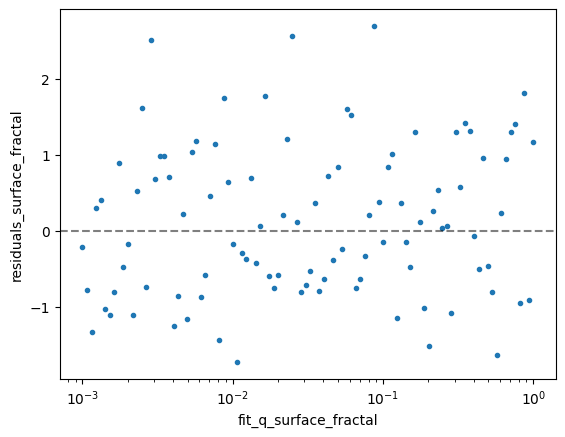

In [17]:
ds_result.isel(sample=data_index).residuals_surface_fractal.plot( x='fit_q_surface_fractal', xscale='log', marker='.', ls='None', add_legend=False)
plt.gca().axhline(y=0, color='k', linestyle='--', alpha=0.5)


Vary the `data_index` variable from two cells up and see how well we fit each individual data.


We can also plot the fit parameters

Text(0.5, 0, 'Sample index')

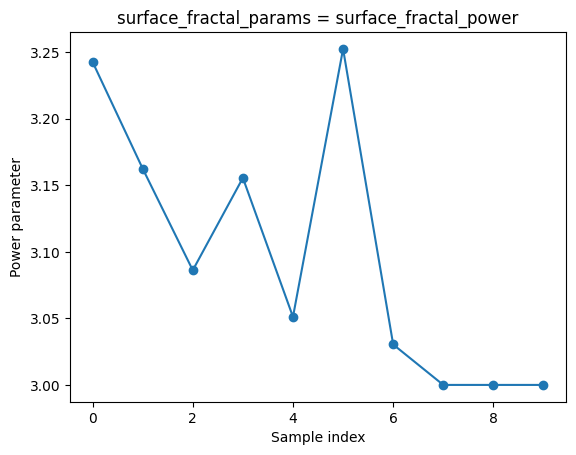

In [18]:
# Plot the power parameter (index 1 in surface_fractal_params)
ds_result.sel(surface_fractal_params='surface_fractal_power').surface_fractal_fit_val.plot(marker='o')
plt.ylabel('Power parameter')
plt.xlabel('Sample index')


## Conclusion
 
In this tutorial, we demonstrated how to use the AutoSAS module to fit small-angle scattering (SAS) data. We:

1. Loaded  synthetic dataset with 10 samples and fit it using a surface fractal model
2. Visualized the fits by plotting the data and model curves on log-log axes
3. Analyzed the quality of the fits by examining the residuals between the model and data
4. Explored how the model parameters vary across different samples

The AutoSAS module provides a flexible framework for fitting SAS data with different models, evaluating fit quality, and extracting physical parameters. 
